# Convolutional Autoencoder


> Imports



In [ ]:
import os
import math
import numpy as np
from numpy import array
from numpy import hstack
import pandas as pd
import netCDF4
import xarray as xr
import pickle
import tensorflow as tf
import seaborn as sns

import keras
from keras import layers, losses, regularizers
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.models import Model, load_model
from keras.layers import Input, Dense, Flatten, Reshape, LeakyReLU, Cropping2D, RepeatVector, TimeDistributed, LSTM

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, roc_curve, auc, precision_recall_curve

import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/My Drive/')
os.getcwd()
if not os.path.exists('data'):
        os.makedirs('data')
if not os.path.exists('JULES'):
        os.makedirs('JULES')
        



> Download the monthly data from 1961-1900 in advance and deposit it in the cloud folder. Iterate through the folder to get the paths.



In [ ]:
# check mse
def check_mse(comp, original):
  total_mse = []
  for i in range(comp.shape[0]):
    this_mse = np.linalg.norm(comp[i]-original[i]) / np.linalg.norm(original[i])
    # this_mse = np.linalg.norm(comp[i]-original[i]) / (144*192)
    total_mse.append(this_mse)
  total_mse2 = np.array(total_mse)
  print("The average MSE is ", np.mean(total_mse2))
  print(total_mse2.shape)
  x = range(len(total_mse))
  plt.scatter(x, total_mse, alpha=0.6)
  plt.show()
  return np.mean(total_mse2)



> READ the data from csv


In [ ]:
rain_df = pd.read_csv('JULES/pt_rain.csv', index_col=0)
print(rain_df.head(5))
rain_data = rain_df.values
print(rain_data.shape)
rain_data[np.isnan(rain_data)] = -0.001
print(rain_data[0])


    0   1   2   3   4   5   6   7   8   9  ...  27638  27639  27640  27641  \
0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...    NaN    NaN    NaN    NaN   
1 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...    NaN    NaN    NaN    NaN   
2 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...    NaN    NaN    NaN    NaN   
3 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...    NaN    NaN    NaN    NaN   
4 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...    NaN    NaN    NaN    NaN   

   27642  27643  27644  27645  27646  27647  
0    NaN    NaN    NaN    NaN    NaN    NaN  
1    NaN    NaN    NaN    NaN    NaN    NaN  
2    NaN    NaN    NaN    NaN    NaN    NaN  
3    NaN    NaN    NaN    NaN    NaN    NaN  
4    NaN    NaN    NaN    NaN    NaN    NaN  

[5 rows x 27648 columns]
(360, 27648)
[-0.001 -0.001 -0.001 ... -0.001 -0.001 -0.001]




> Normalization



In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()
rain_data = min_max_scaler.fit_transform(rain_data)
rain_data = np.array(rain_data, dtype = np.float32)


In [ ]:
print(np.max(rain_data))
print(np.mean(rain_data))
print(np.min(rain_data))


1.0
0.062905155
0.0


In [ ]:
pca = PCA(n_components=20)
pca.fit(rain_data)
encode_pca = pca.transform(rain_data)
reconPCA=pca.inverse_transform(encode_pca)
check_mse(reconPCA, rain_data)




> RESHAPE the data that suitable for the learnning model

> **(sample_number, row_number, column_number, channel)**


In [ ]:

rain_data = np.reshape(rain_data, (360, 144, 192, 1))
print(rain_data.shape)


(360, 144, 192, 1)




> Splitting the data into a training set and a test set （8 : 2）


In [ ]:
newarr = np.array_split(rain_data, 6)
cae_rain_train = np.vstack((newarr[0], newarr[1], newarr[2], newarr[3]))
cae_rain_test = newarr[5]
cae_rain_val = newarr[4]

print(cae_rain_train.shape)
print(cae_rain_val.shape)
print(cae_rain_test.shape)

cae_rain_train = cae_rain_train.astype('float32') # 60 years
cae_rain_val = cae_rain_val.astype('float32') # 15 years
cae_rain_test = cae_rain_test.astype('float32') # 15 years


(240, 144, 192, 1)
(60, 144, 192, 1)
(60, 144, 192, 1)




> Define the Convolutional Autoencoder network


In [ ]:
def my_encoder_model(input_img):
  act_f = str("relu")# relu

  x = layers.Conv2D(32, (15, 20), activation= act_f, padding='same')(input_img) # large filter
  x = layers.MaxPooling2D((2, 2), padding='same')(x)
  x = layers.Conv2D(32, (10, 15), activation= act_f, padding='same')(x)
  x = layers.MaxPooling2D((2, 2), padding='same')(x)
  x = layers.Conv2D(16, (5, 5), activation= act_f, padding='same')(x)
  x = layers.MaxPooling2D((2, 2), padding='same')(x)
  
  x = Flatten()(x)
  x = LeakyReLU(alpha=0.3)(x)
  x = Dense(450, activation= act_f)(x)
  x = LeakyReLU(alpha=0.3)(x)
  x = Dense(100, activation= act_f)(x)
  x = LeakyReLU(alpha=0.3)(x)
  encoded = Dense(20, activation= act_f)(x)

  return encoded

def my_decoder_model(encoded):
  act_f = str("relu") # relu

  x = Dense(20, activation= act_f)(encoded)
  x = LeakyReLU(alpha=0.3)(x)
  x = Dense(100, activation= act_f)(x)
  x = LeakyReLU(alpha=0.3)(x)
  x = Dense(450, activation= act_f)(x)
  x = LeakyReLU(alpha=0.3)(x)
  x = Reshape((18, 25, 1))(x)

  
  x = layers.Conv2D(16, (5, 5), activation= act_f, padding='same')(x)
  x = layers.UpSampling2D((2, 2))(x)
  x = layers.Conv2D(32, (10, 15), activation= act_f, padding='same')(x)
  x = layers.UpSampling2D((2, 2))(x)
  x = layers.Conv2D(32, (15, 20), activation= act_f, padding='same')(x)
  x = layers.UpSampling2D((2, 2))(x)
  x = Cropping2D(cropping=((0, 0), (8, 0)), data_format=None)(x)
  decoded = layers.Conv2D(1, (15,20), activation='sigmoid', padding='same')(x)
  return decoded


In [ ]:
# input shape
input_img = keras.Input(shape=(144, 192, 1))
# for the encoeded data
encoded = my_encoder_model(input_img)
print(encoded.shape)

# for the encoded data
decoded = my_decoder_model(encoded)
print(decoded.shape)


# combine the encode and decode parts as autoencoder
autoencoder = keras.Model(input_img, decoded)
autoencoder.summary()
autoencoder.compile(optimizer='adam', loss="binary_crossentropy") # 'binary_crossentropy' kullback_leibler_divergence


layer_number = 15
# # this model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)

# this model maps the encoded representation to the original representation
encoded_input = Input(shape=(20,))
decoder = autoencoder.layers[-layer_number](encoded_input)
for i in range(layer_number-1):
  decoder = autoencoder.layers[i-layer_number+1](decoder)
decoder = keras.Model(encoded_input, decoder)


(None, 20)
(None, 144, 192, 1)
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 144, 192, 1)]     0         
                                                                 
 conv2d_7 (Conv2D)           (None, 144, 192, 32)      9632      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 72, 96, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 72, 96, 32)        153632    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 48, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)          

In [ ]:
encoder.summary()
decoder.summary()

In [ ]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.val_loss['batch'].append(logs.get('val_loss'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.val_loss['epoch'].append(logs.get('val_loss'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # plt.plot(iters, np.log(self.losses[loss_type]), 'g', label='train loss')
        # if loss_type == 'epoch':
        #     plt.plot(iters, np.log(self.val_loss[loss_type]), 'k', label='val loss')
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('loss')
        plt.legend(loc="upper right")
        plt.show()



> Train a model



In [ ]:
history = LossHistory()
autoencoder.fit(cae_rain_train, cae_rain_train,
                epochs=1000,
                batch_size=64,
                shuffle=True,
                callbacks=[history], validation_data=(cae_rain_val, cae_rain_val))

In [ ]:
from keras.models import save_model
autoencoder.save("JULES/para_mod/autoencoder_rain.h5")


In [ ]:
from keras.models import load_model
autoencoder2 = load_model('JULES/para_mod/autoencoder_rain.h5')

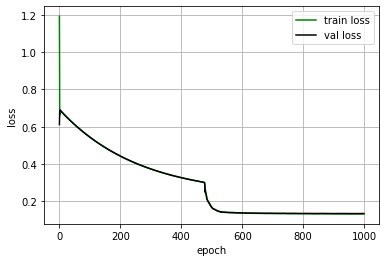

In [ ]:
# Draw acc-loss plots
history.loss_plot('epoch')

In [ ]:
history.loss_plot('epoch') # np.log()

In [ ]:
aa = autoencoder.predict(cae_rain_test)
print(aa.shape)


(60, 144, 192, 1)


In [ ]:
bb = aa-cae_rain_test
print(bb.shape)

(60, 144, 192, 1)




> CHECK MSE



In [ ]:
check_mse(aa, cae_rain_test)

In [ ]:
check_mse(aa, cae_rain_test)

In [ ]:
def show_climate_diff(diff):
  plt.figure(figsize=(24, 12), facecolor='w')
  norm = mpl.colors.Normalize(vmin=-1.0, vmax=1.0)
  for j in range(4):
    plt.subplot(2, 2, j+1)
    monthly_field = np.zeros((144,192))
    for i in range(144):
        for k in range(192):
          monthly_field[i,k] = np.array(diff[j][i][k])
    plt.title(f'The {j + 1} difference')
    plt.imshow(monthly_field)
    sm = plt.cm.ScalarMappable(norm=norm) 
    sm.set_array([])
    plt.colorbar(sm)
  plt.show()
  
def show_climate_comp(comp_data, original_test_data):
  plt.figure(figsize=(24, 12), facecolor='w')
  monthly_field = np.zeros((144, 192))
  norm = mpl.colors.Normalize(vmin=0.0, vmax=1.0)
  for j in range(4):
    plt.subplot(2, 4, j+1)
    monthly_field = np.zeros((144, 192))
    for i in range(144):
        for k in range(192):
          monthly_field[i,k] = np.array(original_test_data[j][i][k])
    plt.title(f'The {j + 1} oringinal')
    plt.imshow(monthly_field)
    # creating ScalarMappable 
    sm = plt.cm.ScalarMappable(norm=norm) 
    sm.set_array([])
    plt.colorbar(sm)
  for j in range(4):
    plt.subplot(2, 4, j+5)
    monthly_field = np.zeros((144, 192))
    for i in range(144):
        for k in range(192):
          monthly_field[i,k] = np.array(comp_data[j][i][k])
    plt.title(f'The {j + 1} prediction')
    plt.imshow(monthly_field)
    sm = plt.cm.ScalarMappable(norm=norm) 
    sm.set_array([])
    plt.colorbar(sm)
  plt.show()


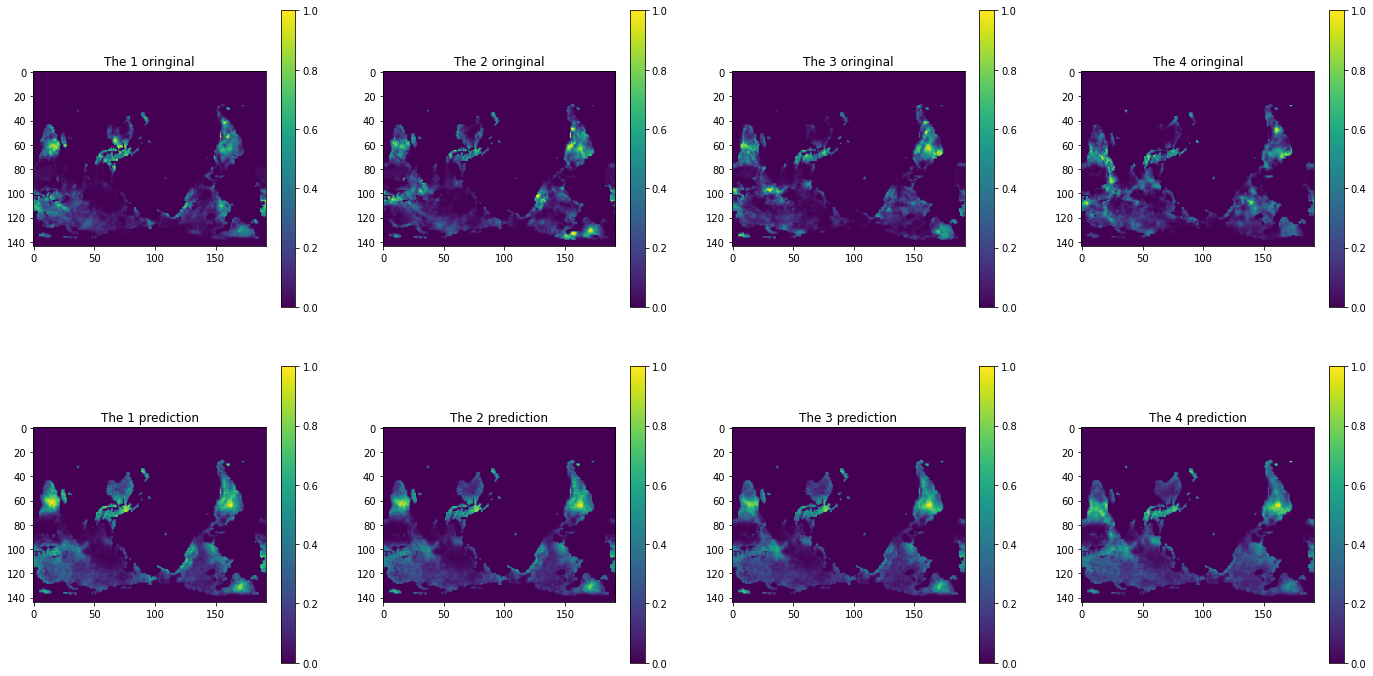

In [ ]:
aa = np.reshape(aa,(60, 144, 192))
cae_test_data = np.reshape(cae_rain_test,(60, 144, 192))
show_climate_comp(aa, cae_test_data)


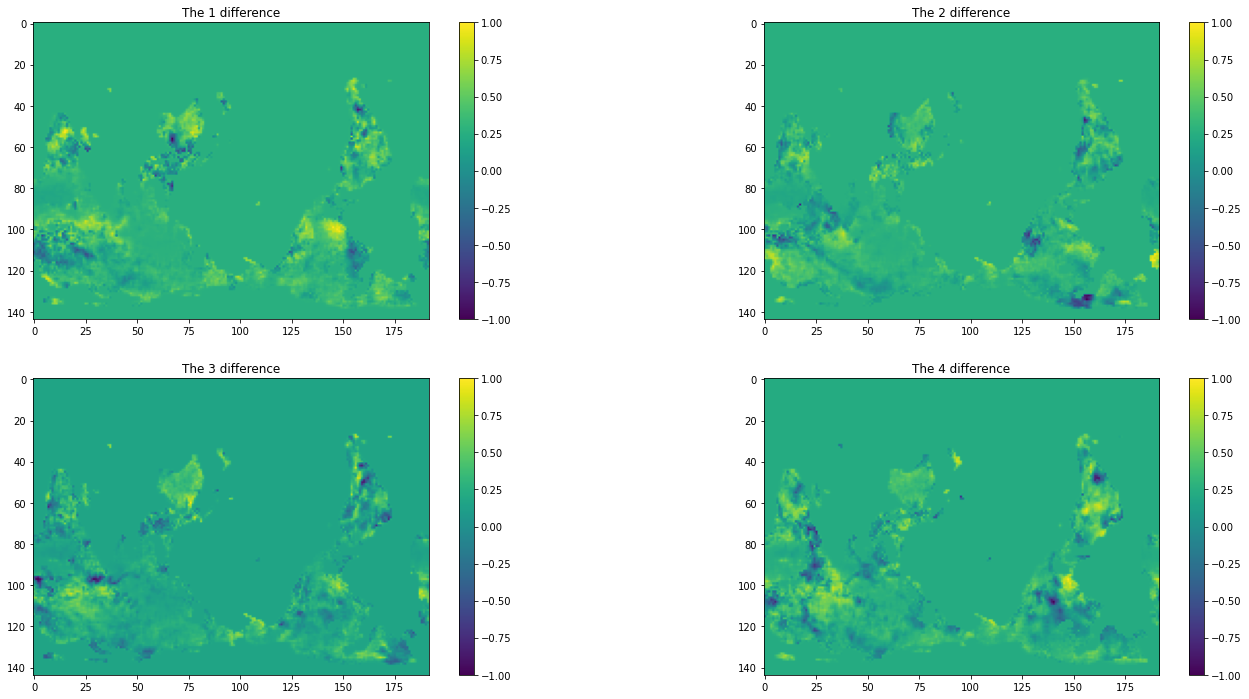

In [ ]:
show_climate_diff(bb)



> **LSTM**

Obtain the encoded data and reshape it for LSTM

In [ ]:
total_train = encoder.predict(cae_rain_train)
total_test = encoder.predict(cae_rain_test)
total_val = encoder.predict(cae_rain_val)

print(total_train.shape)
print(total_val.shape)
print(total_test.shape)

(240, 20)
(60, 20)
(60, 20)




> Data preprocessing and Data enhencement



In [ ]:
def split_test(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i*6 + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i*6:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
n_steps_in, n_steps_out = 6, 6


x_train, y_train = split_sequences(total_train, n_steps_in, n_steps_out)
print(x_train.shape, y_train.shape)

x_val, y_val = split_sequences(total_val, n_steps_in, n_steps_out)
print(x_val.shape, y_val.shape)

x_test, y_test = split_test(total_test, n_steps_in, n_steps_out)
print(x_test.shape, y_test.shape)


# print (x_test[0], y_test[0])

(229, 6, 20) (229, 6, 20)
(49, 6, 20) (49, 6, 20)
(9, 6, 20) (9, 6, 20)


In [ ]:
def my_LSTM(n_steps_in, n_steps_out, n_features):
  model = keras.Sequential()
  model.add(LSTM(64, activation='relu', input_shape=(n_steps_in, n_features)))
  model.add(RepeatVector(n_steps_out))
  model.add(LSTM(64, activation='relu', return_sequences=True))
  model.add(Dense(100))
  model.add(LeakyReLU(alpha=0.3))
  model.add(TimeDistributed(Dense(n_features)))
  model.compile(optimizer='adam', loss='mse')
  return model
  

In [ ]:
lstm_history = LossHistory()
n_features = x_train.shape[2]
lstm_model = my_LSTM(6, 6, n_features)
lstm_model.fit(x_train, y_train, epochs=1000, verbose=1, callbacks=[lstm_history], validation_data =(x_val, y_val))


In [ ]:
lstm_model.save("JULES/lstm_rain_model.h5")

In [ ]:
lstm_model2 = load_model('JULES/lstm_rain_model.h5')

In [ ]:
# Draw acc-loss plots
lstm_history.loss_plot('epoch')

In [ ]:
yhat = lstm_model.predict(x_test, verbose=0)
print(yhat.shape)

(9, 6, 20)


In [ ]:
# MSE2 = mean_squared_error(yhat, y_test)
# print("MSE2:", MSE2)



> Decode the prediction data from 6-72



In [ ]:
y_predict = np.reshape(yhat, (54, 20))
y_decode = decoder.predict(y_predict)
print(y_decode.shape)

(54, 144, 192, 1)



> Output the image, compare the decode value with the original value and determine the performance of the CAE






> MES



In [ ]:
original_test_data = np.zeros((54, 144, 192,1))
for i in range(54):
  original_test_data[i] = cae_rain_test[i+6]
print(original_test_data.shape)


(54, 144, 192, 1)


In [ ]:
check_mse(y_decode, original_test_data)


> The first line is the original data

> The second line is the decode data

It can be seen that the basic characteristics of the data have not changed much, and the network structure will be adjusted later to ensure the accuracy.

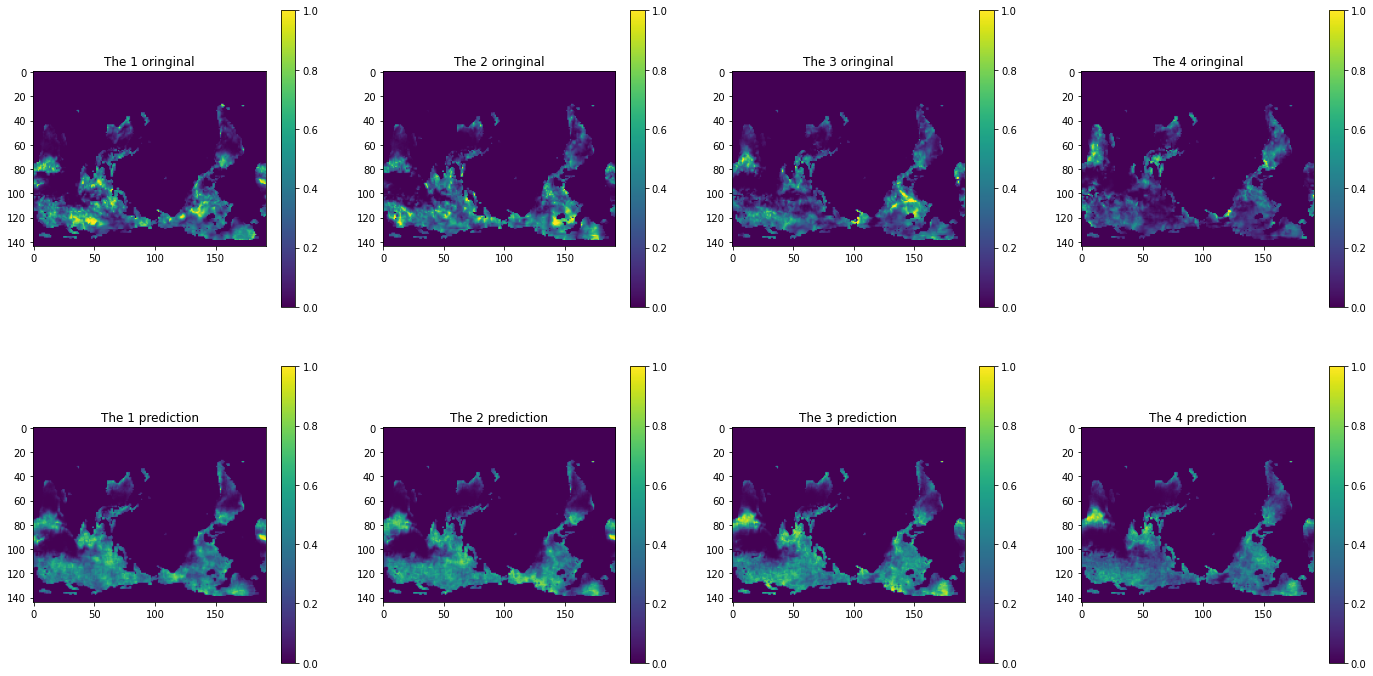

In [ ]:
comp = np.reshape(y_decode,(54, 144, 192))
original = np.reshape(original_test_data,(54, 144, 192))
show_climate_comp(comp, original)

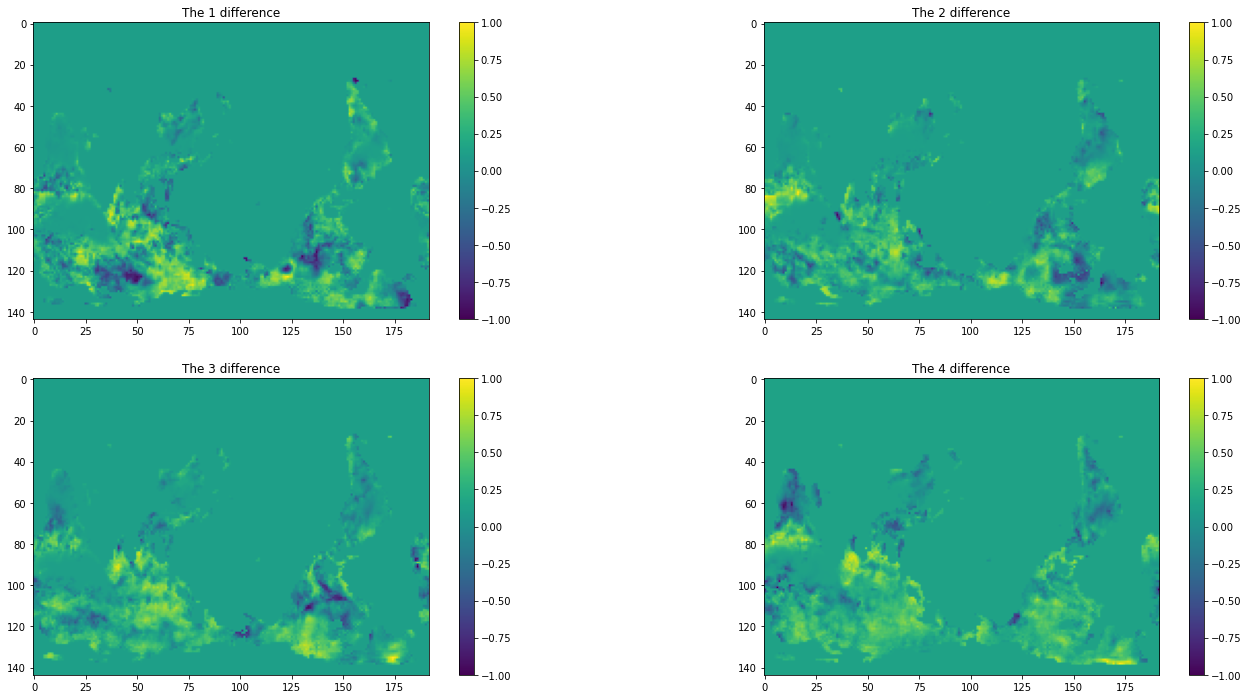

In [ ]:
difference = comp - original
show_climate_diff(difference)